# 6. Review Features: Votes

## Setup

In [189]:
import ast
import nltk
import numpy as np
import pandas as pd
import re
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVR

In [2]:
nltk.download('stopwords')
from nltk.corpus import stopwords
languages = [
    'arabic', 'azerbaijani', 'bengali', 'danish', 'dutch', 'english',
    'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian',
    'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian',
    'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish'
]
english_stopwords = set(stopwords.words('english'))
all_stopwords = set()
for language in languages:
    all_stopwords |= set(stopwords.words(language))

[nltk_data] Downloading package stopwords to C:\Users\Conor Mac
[nltk_data]     Amhlaoibh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
DIR_SAMPLE = '../data/samples/'
PATH_SAMPLES = DIR_SAMPLE + 'review_sentiment/%s.csv'
DIR_RESULT = '../data/results/bert/'
PATH_RESULTS_HP = DIR_RESULT + 'review_votes/hyperparams/eng_any_any_100000_%d_train.txt'
PATH_RESULTS_OPT = DIR_RESULT + 'review_votes/optimal/%s_10_%s.txt'

## Data Reading and Writing

In [4]:
def preprocess_text(text, is_english=True):
    if is_english:
        text = text.lower()
        stopword_list = english_stopwords
    else:
        stopword_list = all_stopwords
    text = re.sub(r'[^\w\s]', ' ', text, re.UNICODE)
    text = ' '.join([
        word
        for word in text.split()
        if word not in stopword_list
    ])
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [180]:
def read_data(sample_name, train_size=0.9, seed=None):
    df = pd.read_csv(PATH_SAMPLES % sample_name)[['votes_up', 'text']].reset_index(drop=True)
    if sample_name.startswith('eng'):
        df['text'] = df['text'].apply(lambda text: preprocess_text(text, is_english=True))
    else:
        df['text'] = df['text'].apply(lambda text: preprocess_text(text, is_english=False))
    scaler = RobustScaler()
    df['votes_up_scaled'] = scaler.fit_transform(np.array(df['votes_up']).reshape(-1, 1))
    train, validation = train_test_split(df, train_size=train_size, random_state=seed)
    return train, validation

## Hyperparameter Tuning

In [14]:
sample_name = 'eng_any_any_100000'
seed = 1337
train, validation = read_data(sample_name, seed=seed)
Xt, Yt = train['text'].tolist(), train['votes_up_scaled'].tolist()
Xv, Yv = validation['text'].tolist(), validation['votes_up_scaled'].tolist()

In [15]:
# fit TFIDF models first
ngram_ranges = [(1, 2), (1, 3), (1, 4)]
Xt_tfidfs, Xv_tfidfs = [], []
for ngram_range in ngram_ranges:
    tfidf = TfidfVectorizer(ngram_range=ngram_range, binary=True, smooth_idf=False)
    Xt_tfidfs.append(tfidf.fit_transform(Xt))
    Xv_tfidfs.append(tfidf.transform(Xv))

In [16]:
results = {}

In [49]:
results['bl'] = {}
bl_mean = DummyRegressor(strategy='mean')
scores = cross_val_score(bl_mean, Xt, Yt, scoring='neg_mean_squared_error', cv=5)
mean, std = round(scores.mean(), 4), round(scores.std(), 4)
results['bl']['mean'] = (mean, std)
bl_const = DummyRegressor(strategy='median')
scores = cross_val_score(bl_const, Xt, Yt, scoring='neg_mean_squared_error', cv=5)
mean, std = round(scores.mean(), 4), round(scores.std(), 4)
results['bl']['median'] = (mean, std)

In [ ]:
for i, ngram_range in enumerate(ngram_ranges):
    print(f'=== TFIDF: ngram_range=(1,{ngram_range[1]}) ===')
    Xt_tfidf = Xt_tfidfs[i]
    Xv_tfidf = Xv_tfidfs[i]
    results[ngram_range] = {}
    # SGDRegressor
    alphas = [0.001, 0.0001, 0.00001, 0.000001]
    results[ngram_range]['sgd'] = {}
    for alpha in alphas:
        print(f'>>> SGDRegressor (alpha={alpha}) <<<')
        model = SGDRegressor(penalty='l2', alpha=alpha, max_iter=1000)
        scores = cross_val_score(model, Xt_tfidf, Yt, scoring='neg_mean_squared_error', cv=5)
        mean, std = round(scores.mean(), 4), round(scores.std(), 4)
        print(f'mean={mean}, std={std}')
        results[ngram_range]['sgd'][alpha] = (mean, std)
    # Ridge
    alphas = [0.01, 0.1, 1, 10]
    results[ngram_range]['ridge'] = {}
    for alpha in alphas:
        print(f'>>> Ridge (alpha={alpha}) <<<')
        model = Ridge(alpha=alpha)
        scores = cross_val_score(model, Xt_tfidf, Yt, scoring='neg_mean_squared_error', cv=5)
        mean, std = round(scores.mean(), 4), round(scores.std(), 4)
        print(f'mean={mean}, std={std}')
        results[ngram_range]['ridge'][alpha] = (mean, std)
    # LinearSVR
    Cs = [0.01, 0.1, 1, 10]
    results[ngram_range]['lsvr'] = {}
    for C in Cs:
        print(f'>>> LinearSVR (C={C}) <<<')
        model = LinearSVR(C=C, max_iter=1000)
        scores = cross_val_score(model, Xt_tfidf, Yt, scoring='neg_mean_squared_error', cv=5)
        mean, std = round(scores.mean(), 4), round(scores.std(), 4)
        print(f'mean={mean}, std={std}')
        results[ngram_range]['lsvr'][C] = (mean, std)

In [17]:
results

{'bl': {'mean': (-125.1907, 15.1508), 'const': (-130.7273, 15.2683)},
 (1,
  2): {'sgd': {0.001: (-123.5203, 15.0138),
   0.0001: (-122.5639, 14.7222),
   1e-05: (-122.7464, 14.5719),
   1e-06: (-122.7958, 14.5507)}, 'ridge': {0.01: (-142.2953, 14.0691),
   0.1: (-135.598, 14.6341),
   1: (-126.1789, 14.3062),
   10: (-122.5964, 14.7403)}, 'lsvr': {0.01: (-128.0929, 15.2287),
   0.1: (-127.1875, 15.1848),
   1: (-126.2715, 15.1207),
   10: (-124.0167, 14.9298)}},
 (1,
  3): {'sgd': {0.001: (-123.9634, 15.0614),
   0.0001: (-122.7927, 14.7957),
   1e-05: (-122.7121, 14.6356),
   1e-06: (-122.7217, 14.6127)}, 'ridge': {0.01: (-132.0232, 13.2152),
   0.1: (-129.17, 13.793),
   1: (-124.4565, 14.1703),
   10: (-122.8402, 14.8114)}, 'lsvr': {0.01: (-128.3311, 15.2344),
   0.1: (-127.3462, 15.1942),
   1: (-126.296, 15.1258),
   10: (-123.8826, 14.9355)}},
 (1,
  4): {'sgd': {0.001: (-124.1938, 15.0835),
   0.0001: (-123.0378, 14.8443),
   1e-05: (-122.8663, 14.6866),
   1e-06: (-122.8615, 1

## Plotting Setup

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter

In [9]:
FONT_SIZE_S = 15
FONT_SIZE_L = 18
TICK_DIR = 'in'
TICK_SIZE_S = 3.0
TICK_SIZE_L = 5.0

def init_plt():
    plt.style.use('default')
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.size'] = FONT_SIZE_S
    plt.rcParams['legend.fontsize'] = FONT_SIZE_S
    plt.rcParams['xtick.direction'] = TICK_DIR
    plt.rcParams['ytick.direction'] = TICK_DIR
    plt.rcParams['xtick.major.size'] = TICK_SIZE_L
    plt.rcParams['xtick.minor.size'] = TICK_SIZE_S
    plt.rcParams['ytick.major.size'] = TICK_SIZE_L
    plt.rcParams['ytick.minor.size'] = TICK_SIZE_S
    plt.rcParams['axes.linewidth'] = 0.8
    plt.rcParams['axes.formatter.limits'] = (-9, 10)
    plt.rcParams['legend.handlelength'] = 2.0
    plt.rcParams['savefig.dpi'] = 400
    plt.rcParams['savefig.bbox'] = 'tight'

def init_ax(ax, only_vertical=False):
    if not only_vertical:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    return ax

def remove_log_ticks(ax):
    plt.rcParams['xtick.minor.size'] = 0

init_plt()

In [10]:
DIR_FIGS = '../figures/04_features/review_votes/'

## Plot Base Hyperparameter Results

In [156]:
def convert_result_to_data(result):
    X, Y, E = [], [], []
    for x, (y, e) in result.items():
        X.append(x)
        Y.append(y)
        E.append(e)
    return X, Y, E

def plot_base_hp_results(results):
    # line styles
    # set up subplots
    fig = plt.figure(figsize=(9, 6))
    plt.subplots_adjust(bottom=0, left=0, top=1, right=1, wspace=0.2)
    p1 = fig.add_subplot(2, 2, 1)
    p2 = fig.add_subplot(2, 2, 2)
    p3 = fig.add_subplot(2, 2, (3, 4))
    styles = (cycler('marker', ['^','o', 'D', 'x']) * cycler('color', ['#111', '#aaa', '#666']))
    p1.set_prop_cycle(styles)
    p2.set_prop_cycle(styles)
    p3.set_prop_cycle(styles)
    # plot actual results
    for label in ['sgd', 'ridge', 'lsvr']:
        off = {'sgd':0.15,'ridge':0.15,'lsvr':-0.15}[label]
        for N in [2, 3, 4]:
            X, Y, E = convert_result_to_data(results[(1, N)][label])
            X = np.array([{1e-6:-6,1e-5:-5,1e-4:-4,1e-3:-3,1e-2:-2,1e-1:-1,1e0:0,1e1:1}[x] for x in X])
            new_label = 'Ridge' if label == 'ridge' else label.upper()
            p1.errorbar(X + off, Y, yerr=E, elinewidth=1, capsize=5, label=f'${N}$-gram {new_label}')
            p2.errorbar(X + off, Y, yerr=E, elinewidth=1, capsize=5, label=f'${N}$-gram {new_label}')
            p3.errorbar(X + off, Y, yerr=E, elinewidth=1, capsize=5, label=f'${N}$-gram {new_label}')
    # plot baseline results
    #X_rng = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
    X_rng = [-6, -5, -4, -3, -2, -1, 0, 1]
    for label in ['mean', 'median']:
        Y = [results['bl'][label][0]] * len(X_rng)
        E = [results['bl'][label][1]] * len(X_rng)
        label_name = {'mean':'Mean','median':'Median'}[label]
        p1.errorbar(X_rng, Y, yerr=E, elinewidth=1, capsize=5, label=f'Baseline {label_name}')
        p2.errorbar(X_rng, Y, yerr=E, elinewidth=1, capsize=5, label=f'Baseline {label_name}')
        p3.errorbar(X_rng, Y, yerr=E, elinewidth=1, capsize=5, label=f'Baseline {label_name}')
    # plot configuration
    # plot 1
    #p1.set_xlim([7e-7, 1.5e-3])
    p1.set_xlim(-6.5, -2.5)
    p1.set_ylim([-160, -100])
    #p1.set_xscale('log')
    p1.set_xticks([-6, -5, -4, -3])
    p1.set_xticklabels(['$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$'])
    p1.set_ylabel('Loss (NMSE)')
    init_ax(p1, only_vertical=True)
    #remove_log_ticks(p1)
    # plot 2
    #p2.set_xlim([7e-3, 1.5e1])
    p2.set_xlim([-2.5, 1.5])
    p2.set_ylim([-160, -100])
    #p2.set_xscale('log')
    p2.set_xticks([-2, -1, 0, 1])
    p2.set_xticklabels(['$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$'])
    init_ax(p2, only_vertical=True)
    #remove_log_ticks(p2)
    # plot 3
    #p3.set_xlim([7e-7, 1.5e1])
    p3.set_xlim([-6.5, 1.5])
    p3.set_ylim([-200, -50])
    #p3.set_xscale('log')
    p3.set_xticks([-6, -5, -4, -3, -2, -1, 0, 1])
    p3.set_xticklabels(['$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$'])
    p3.set_xlabel(f'Hyperparameter ($\\alpha, C$)')
    p3.set_ylabel('Loss (NMSE)')
    init_ax(p3, only_vertical=True)
    #remove_log_ticks(p3)
    # connect plots
    p3.fill_between((-6.2, -2.8), -160, -100, facecolor='#f0f0f0')
    p3.fill_between((-2.2, 1.2), -160, -100, facecolor='#f0f0f0')
    fig.add_artist(ConnectionPatch(xyA=(-6.5, -160), coordsA=p1.transData, xyB=(-6.2, -100), coordsB=p3.transData, color='#aaa'))
    fig.add_artist(ConnectionPatch(xyA=(-2.5, -160), coordsA=p1.transData, xyB=(-2.8, -100), coordsB=p3.transData, color='#aaa'))
    fig.add_artist(ConnectionPatch(xyA=(-2.5, -160), coordsA=p2.transData, xyB=(-2.2, -100), coordsB=p3.transData, color='#aaa'))
    fig.add_artist(ConnectionPatch(xyA=(1.5, -160), coordsA=p2.transData, xyB=(1.2, -100), coordsB=p3.transData, color='#aaa'))
    # finalise
    p2.legend(loc='upper left', bbox_to_anchor=(1.025, 1.025))
    plt.savefig(DIR_FIGS + f'plot_hyperparams_base.png')
    plt.show()

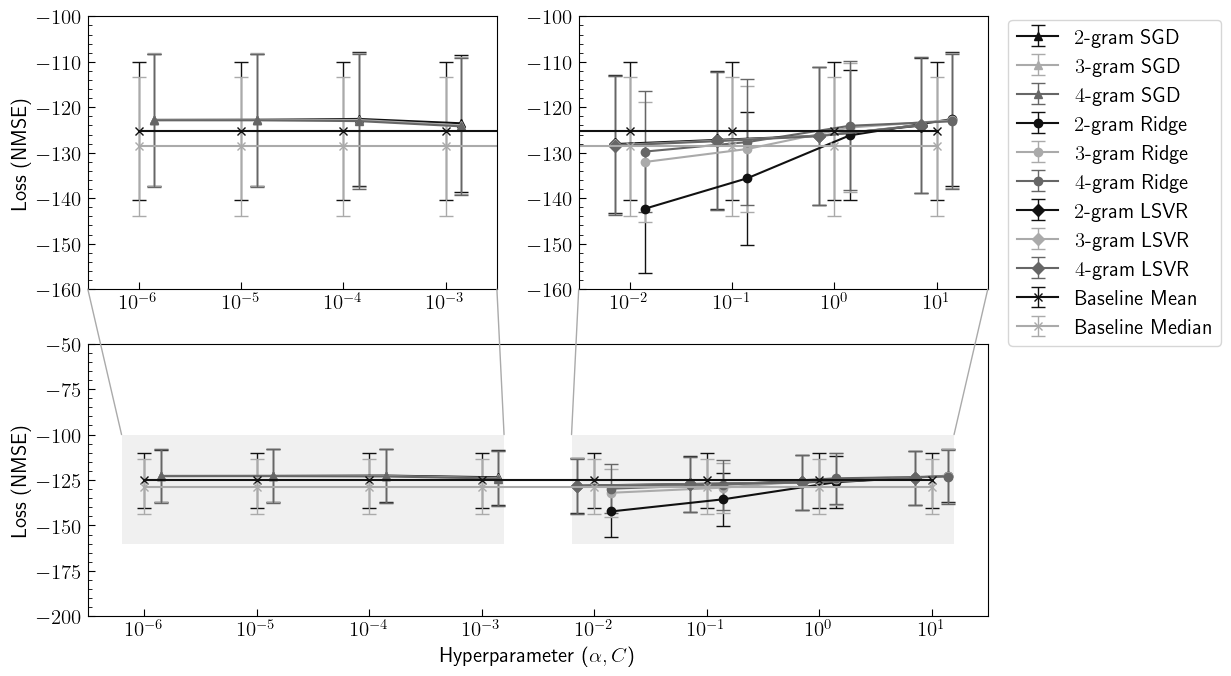

In [157]:
plot_base_hp_results(results)

## Plot Bert Hyperparameter Results

In [52]:
def load_bert_train_results(filename):
    with open(filename, 'r') as f:
        data = ast.literal_eval(f.readlines()[1])
    return data

In [69]:
def plot_bert_hp_results():
    # set up plot
    styles = (cycler('color', ['#aaa', '#111', '#666']) * cycler('marker', ['2', 'x']))
    ax = plt.gca()
    ax.set_prop_cycle(styles)
    # load and plot results
    batch_sizes = [16, 32, 64]
    num_epochs = [2, 3, 4]
    i = 0
    for batch_size in batch_sizes:
        Y1, Y2 = [], []
        for num_epoch in num_epochs:
            data = load_bert_train_results(PATH_RESULTS_HP % i)
            Y1.append(-data['loss'][-1]) # convert to NMSE
            Y2.append(-data['val_loss'][-1]) # convert to NMSE
            i += 1
        plt.plot(num_epochs, Y1, label=f'Training ($n = {batch_size}$)')
        plt.plot(num_epochs, Y2, label=f'Validation ($n = {batch_size}$)')
    # plot configuration
    plt.xticks(num_epochs)
    plt.ylim([-150, -100])
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss (NMSE)')
    # change legend order
    hs, ls = ax.get_legend_handles_labels()
    ixs = [1, 3, 5, 0, 2, 4]
    plt.legend([hs[ix] for ix in ixs], [ls[ix] for ix in ixs], loc='upper left', bbox_to_anchor=(1, 1))
    # save and show
    plt.savefig(DIR_FIGS + f'plot_hyperparams_bert.png')
    plt.show()

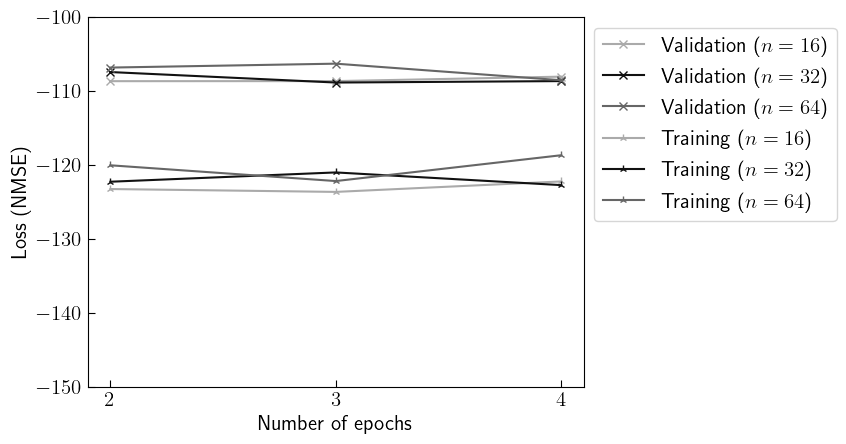

In [70]:
plot_bert_hp_results()

## Full Results

In [161]:
def load_bert_test_results(sample_name):
    path_train = PATH_RESULTS_OPT % (sample_name, 'train')
    path_test = PATH_RESULTS_OPT % (sample_name, 'test')
    with open(path_train, 'r') as f:
        data = ast.literal_eval(f.readlines()[1])
        train_loss = -data['loss'][-1] # convert to NMSE
        val_loss = -data['val_loss'][-1] # convert to NMSE
    with open(path_test, 'r') as f:
        Yt, Yp = map(ast.literal_eval, f.readlines())
    return train_loss, val_loss, Yt, Yp

In [193]:
def get_base_results_for_sample(sample_name, seed=None):
    # load sample data
    train, validation = read_data(sample_name, seed=seed)
    Xt, Yt = train['text'].tolist(), train['votes_up_scaled'].tolist()
    Xv, Yv = validation['text'].tolist(), validation['votes_up_scaled'].tolist()
    # vectorise sample data
    tfidf2 = TfidfVectorizer(ngram_range=(1, 2), binary=True, smooth_idf=False)
    Xt_tfidf2 = tfidf2.fit_transform(Xt)
    Xv_tfidf2 = tfidf2.transform(Xv)
    tfidf3 = TfidfVectorizer(ngram_range=(1, 3), binary=True, smooth_idf=False)
    Xt_tfidf3 = tfidf3.fit_transform(Xt)
    Xv_tfidf3 = tfidf3.transform(Xv)
    # init results
    results = {}
    # get results for baseline
    model_bl = DummyRegressor(strategy='mean')
    model_bl.fit(Xt, Yt)
    results['bl'] = {}
    results['bl']['mse'] = -mean_squared_error(Yv, model_bl.predict(Xv))
    results['bl']['r2'] = r2_score(Yv, model_bl.predict(Xv))
    print('>>>', 'bl_mse =', results['bl']['mse'])
    print('>>>', 'bl_r2 =', results['bl']['r2'])
    # get results for SGDRegressor
    model_sgd = SGDRegressor(penalty='l2', alpha=1e-4, max_iter=1000)
    model_sgd.fit(Xt_tfidf2, Yt)
    results['sgd'] = {}
    results['sgd']['mse'] = -mean_squared_error(Yv, model_sgd.predict(Xv_tfidf2))
    results['sgd']['r2'] = r2_score(Yv, model_sgd.predict(Xv_tfidf2))
    print('>>>', 'sgd_mse =', results['sgd']['mse'])
    print('>>>', 'sgd_r2 =', results['sgd']['r2'])
    # get results for Ridge
    model_ridge = Ridge(alpha=10)
    model_ridge.fit(Xt_tfidf2, Yt)
    results['ridge'] = {}
    results['ridge']['mse'] = -mean_squared_error(Yv, model_ridge.predict(Xv_tfidf2))
    results['ridge']['r2'] = r2_score(Yv, model_ridge.predict(Xv_tfidf2))
    print('>>>', 'ridge_mse =', results['ridge']['mse'])
    print('>>>', 'ridge_r2 =', results['ridge']['r2'])
    # get results for LinearSVR
    model_lsvr = LinearSVR(C=10, max_iter=1000)
    model_lsvr.fit(Xt_tfidf3, Yt)
    results['lsvr'] = {}
    results['lsvr']['mse'] = -mean_squared_error(Yv, model_lsvr.predict(Xv_tfidf3))
    results['lsvr']['r2'] = r2_score(Yv, model_lsvr.predict(Xv_tfidf3))
    print('>>>', 'lsvr_mse =', results['lsvr']['mse'])
    print('>>>', 'lsvr_r2 =', results['lsvr']['r2'])
    # load pre-gathered BERT results
    _, _, Yt, Yp = load_bert_test_results(sample_name)
    results['bert'] = {}
    results['bert']['mse'] = -mean_squared_error(Yt, Yp)
    results['bert']['r2'] = r2_score(Yt, Yp)
    print('>>>', 'bert_mse =', results['bert']['mse'])
    print('>>>', 'bert_r2 =', results['bert']['r2'])
    return results

In [194]:
sample_names = [
    'eng_any_any_100000', 'eng_any_long_100000', 'eng_any_short_100000',
    'any_any_any_100000', 'any_any_long_100000', 'any_any_short_100000',
]
seed = 1337
test_results = {}

In [195]:
for sample_name in sample_names:
    print(f'=== {sample_name} ===')
    test_results[sample_name] = get_base_results_for_sample(sample_name, seed=seed)

=== eng_any_any_100000 ===
>>> bl_mse = -127.65523160000001
>>> bl_r2 = -2.8816120199337547e-05


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


>>> sgd_mse = -124.6709801919996
>>> sgd_r2 = 0.023349288835960325
>>> ridge_mse = -124.73612874297186
>>> ridge_r2 = 0.022838926452185326
>>> lsvr_mse = -124.81165272951029
>>> lsvr_r2 = 0.022247284716080395
>>> bert_mse = -155.69892141575434
>>> bert_r2 = 0.008355281429357042
=== eng_any_long_100000 ===
>>> bl_mse = -67.11545259343364
>>> bl_r2 = -0.00010002595691549487


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


>>> sgd_mse = -64.74376144251536
>>> sgd_r2 = 0.035240991497941354
>>> ridge_mse = -64.75835603626804
>>> ridge_r2 = 0.03502351470195986
>>> lsvr_mse = -65.24174116481755
>>> lsvr_r2 = 0.02782050167099559
>>> bert_mse = -50.025513321531704
>>> bert_r2 = -0.0008218458030564424
=== eng_any_short_100000 ===
>>> bl_mse = -437.24274346864195
>>> bl_r2 = -0.00013345334068470827


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


>>> sgd_mse = -437.2181810452336
>>> sgd_r2 = -7.727012961322721e-05
>>> ridge_mse = -437.48175422924663
>>> ridge_r2 = -0.0006801580280921815
>>> lsvr_mse = -437.9640759044391
>>> lsvr_r2 = -0.001783403421725227
>>> bert_mse = -314.7519438409787
>>> bert_r2 = -0.005981329183718964
=== any_any_any_100000 ===
>>> bl_mse = -480.85324904000004
>>> bl_r2 = -2.955775392887716e-06


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


>>> sgd_mse = -466.5566918083948
>>> sgd_r2 = 0.02972877530380813
>>> ridge_mse = -466.31388641248924
>>> ridge_r2 = 0.030233723776275645
>>> lsvr_mse = -470.0905066189299
>>> lsvr_r2 = 0.022379703081143232
>>> bert_mse = -569.0446299554014
>>> bert_r2 = 8.872765919987202e-06
=== any_any_long_100000 ===
>>> bl_mse = -62.12546241506945
>>> bl_r2 = -2.639205049703719e-05


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


>>> sgd_mse = -60.04692487811544
>>> sgd_r2 = 0.03343158657884926
>>> ridge_mse = -60.01460649148632
>>> ridge_r2 = 0.03395181191514829
>>> lsvr_mse = -60.00337612075165
>>> lsvr_r2 = 0.03413258589558388
>>> bert_mse = -68.53604628106359
>>> bert_r2 = -0.015115218974322886
=== any_any_short_100000 ===
>>> bl_mse = -335.3179617777778
>>> bl_r2 = -5.2096636012688435e-05


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


>>> sgd_mse = -334.01519138893354
>>> sgd_r2 = 0.0038332850235072158
>>> ridge_mse = -334.25130859697964
>>> ridge_r2 = 0.0031290891978305035
>>> lsvr_mse = -336.69004886012567
>>> lsvr_r2 = -0.004144208362430124
>>> bert_mse = -264.81446902784614
>>> bert_r2 = 0.013727534704703004


In [210]:
test_results

{'eng_any_any_100000': {'bl': {'mse': -127.65523160000001,
   'r2': -2.8816120199337547e-05},
  'sgd': {'mse': -124.6709801919996, 'r2': 0.023349288835960325},
  'ridge': {'mse': -124.73612874297186, 'r2': 0.022838926452185326},
  'lsvr': {'mse': -124.81165272951029, 'r2': 0.022247284716080395},
  'bert': {'mse': -155.69892141575434, 'r2': 0.008355281429357042}},
 'eng_any_long_100000': {'bl': {'mse': -67.11545259343364,
   'r2': -0.00010002595691549487},
  'sgd': {'mse': -64.74376144251536, 'r2': 0.035240991497941354},
  'ridge': {'mse': -64.75835603626804, 'r2': 0.03502351470195986},
  'lsvr': {'mse': -65.24174116481755, 'r2': 0.02782050167099559},
  'bert': {'mse': -50.025513321531704, 'r2': -0.0008218458030564424}},
 'eng_any_short_100000': {'bl': {'mse': -437.24274346864195,
   'r2': -0.00013345334068470827},
  'sgd': {'mse': -437.2181810452336, 'r2': -7.727012961322721e-05},
  'ridge': {'mse': -437.48175422924663, 'r2': -0.0006801580280921815},
  'lsvr': {'mse': -437.964075904439

## Plot Sample Scores

In [208]:
def plot_sample_scores(sample_name, results):
    keys_to_labels = {
        'bl': 'Baseline', 'sgd': 'SGD', 'ridge': 'Ridge',
        'lsvr': 'SVR', 'bert': 'BERT'
    }
    X, Y1, Y2, labels = [], [], [], []
    for i, (key, value) in enumerate(results[sample_name].items()):
        X.append(i)
        Y1.append(-value['mse'])
        Y2.append(value['r2'])
        labels.append(keys_to_labels[key])
    plt.rcParams['xtick.direction'] = 'out'
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
    plt.subplots_adjust(bottom=0, left=0, top=1, right=1, wspace=0.2)
    ax1 = init_ax(ax1, only_vertical=True)
    ax2 = init_ax(ax2, only_vertical=True)
    ax1.bar(X, Y1, color='darkgrey')
    ylim = {
        'eng_any_any_100000': [0, 170], 'eng_any_long_100000': [0, 80],
        'eng_any_short_100000': [0, 500], 'any_any_any_100000': [0, 600],
        'any_any_long_100000': [0, 80], 'any_any_short_100000': [0, 400]
    }[sample_name]
    ax1.set_ylim(ylim)
    ax1.set_xticks(X, labels)
    ax1.set_ylabel('Loss (MSE)')
    ax1.set_xlabel('Model')
    ax2.bar(X, Y2, color='darkgrey')
    ax2.set_ylim([0, 0.3])
    ax2.set_xticks(X, labels)
    ax2.set_ylabel('$R^2$ score')
    ax2.set_xlabel('Model')
    plt.savefig(DIR_FIGS + f'bars_optimal_{sample_name}.png')
    plt.show()

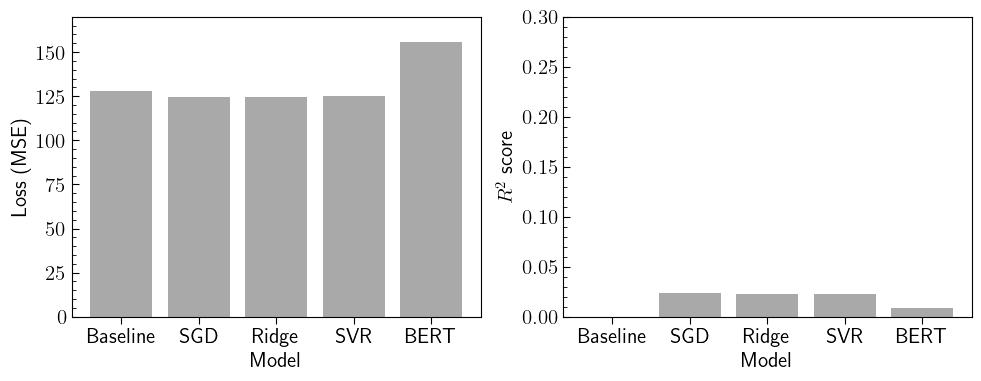

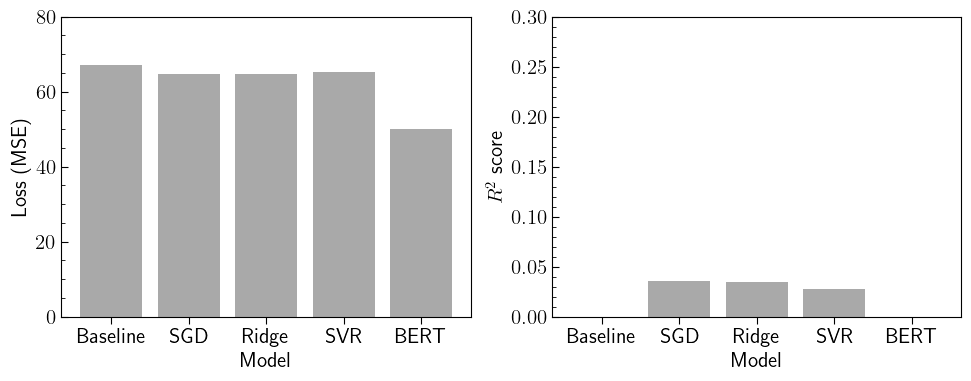

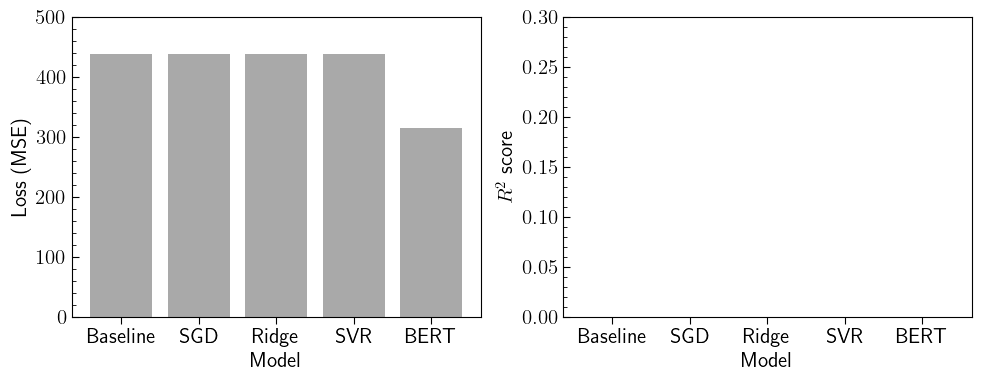

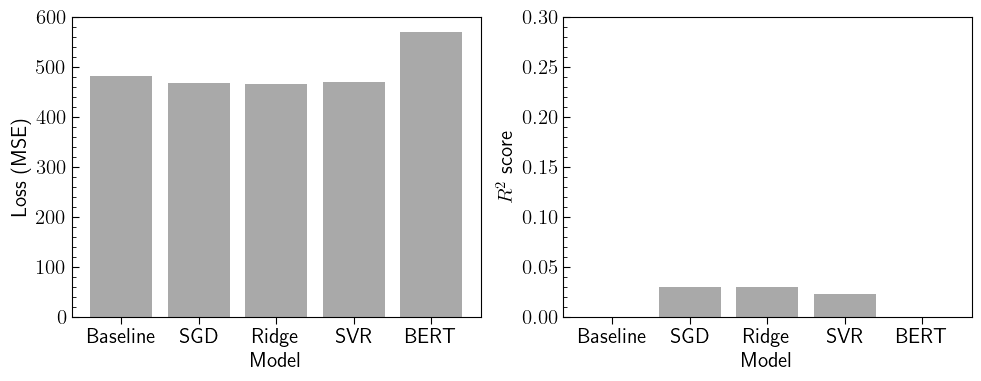

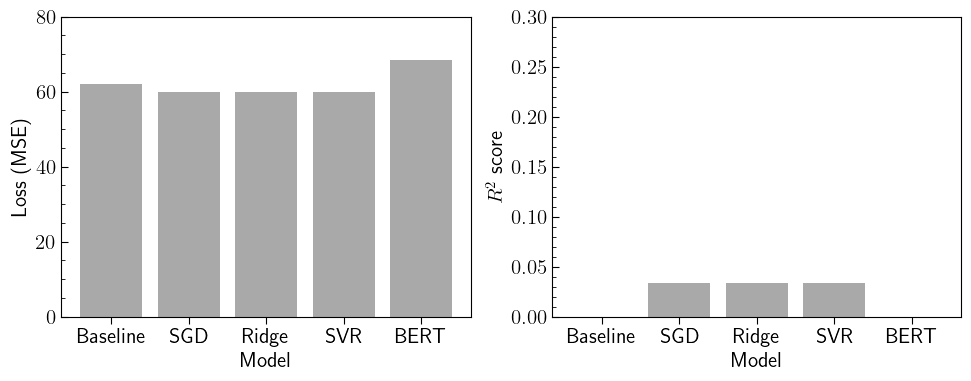

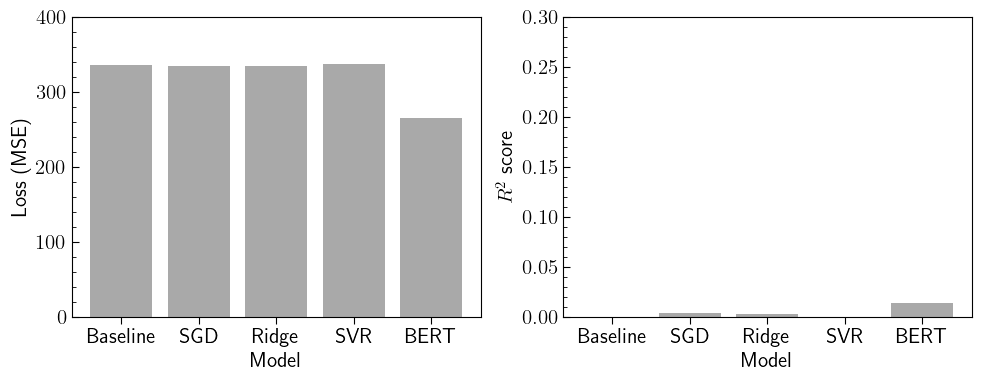

In [209]:
for sample_name in sample_names:
    plot_sample_scores(sample_name, test_results)